# Setting up a unified code framework

## Loading packages


In [1]:
using DifferentialEquations, ModelingToolkit, MethodOfLines, DomainSets, Plots, NLsolve, Sundials, LoopVectorization, Polyester

## Main functions with function type as inputs


In [2]:
# gennerating ODEProblem
function probgeneration!(ratio::Function, γ::Function, initS::Function, initI::Function, dx=0.05)
    # Parameters, variables, and derivatives
    @parameters t x
    @parameters dS dI brn ϵ
    @variables S(..) I(..)
    Dt = Differential(t)
    Dx = Differential(x)
    Dxx = Differential(x)^2
    # 1D PDE and boundary conditions
    eq = [Dt(S(t, x)) ~ dS * Dxx(S(t, x)) - ratio(x, brn, ϵ) * γ(x) * S(t, x) * I(t, x) / (S(t, x) + I(t, x)) + γ(x) * I(t, x),
        Dt(I(t, x)) ~ dI * Dxx(I(t, x)) + ratio(x, brn, ϵ) * γ(x) * S(t, x) * I(t, x) / (S(t, x) + I(t, x)) - γ(x) * I(t, x)]
    bcs = [S(0, x) ~ initS(x),
        I(0, x) ~ initI(x),
        Dx(S(t, 0)) ~ 0.0,
        Dx(S(t, 1)) ~ 0.0,
        Dx(I(t, 0)) ~ 0.0,
        Dx(I(t, 1)) ~ 0.0]
    # Space and time domains
    domains = [t ∈ Interval(0.0, 5.0),
        x ∈ Interval(0.0, 1.0)]
    # PDE system
    @named pdesys = PDESystem(eq, bcs, domains, [t, x], [S(t, x), I(t, x)], [dS => 0.5, dI => 0.1, brn => 3.0, ϵ => 1.0])
    # Method of lines discretization
    # Need a small dx here for accuracy
    order = 2
    discretization = MOLFiniteDifference([x => dx], t)
    # Convert the PDE problem into an ODE problem
    prob = discretize(pdesys, discretization)
    return prob
end
# Main functions calculateing epidemic size
function episize!(prob::ODEProblem, p, n::Int64)
    newprob = remake(prob, p=p) # p = [dS,dI,brn,ϵ]
    steadystateprob = SteadyStateProblem(newprob)
    state = solve(steadystateprob, DynamicSS(Rodas5())) # Rodas5, Tsit5
    y = sum(state[n:end]) / (n - 1)
    return y
end

# plot dI
function episingle!(prob::ODEProblem, vartype::String, Ilim::Dict, p = [0.1,0.1,3.0,0.1], n::Int64=20)
    # p = [ds, di, brn, ϵ]
    N_range = range(Ilim["min"], Ilim["max"], length=Ilim["len"])
    # Ilim = Dict("min" => 0.1, "max" => 2, "len" => 50)
    N_len = Ilim["len"]
    ds, di, brn, ϵ = p
    episize_vector = zeros(N_len)
    if vartype == "S" # ds
        Threads.@threads for j in 1:N_len
            para = [exp(N_range[j]), di, brn, ϵ]
            @inbounds episize_vector[j] = episize!(prob, para, n)
        end
    elseif vartype == "tS" # t * episize
        Threads.@threads for j in 1:N_len
            para = [exp(N_range[j]), di, brn, ϵ]
            @inbounds episize_vector[j] = di * exp(-N_range[j]) * episize!(prob, para, n)
        end
    elseif vartype == "I" # di
        Threads.@threads for j in 1:N_len
            para = [ds, exp(N_range[j]), brn, ϵ]
            @inbounds episize_vector[j] = episize!(prob, para, n)
        end
    elseif vartype == "T" # di/ds
        Threads.@threads for j in 1:N_len
            para = [ds, ds * exp(N_range[j]), brn, ϵ]
            @inbounds episize_vector[j] = episize!(prob, para, n)
        end
    elseif vartype == "E" # ϵ
        Threads.@threads for j in 1:N_len
            para = [ds, di, brn, N_range[j]]
            @inbounds episize_vector[j] = episize!(prob, para, n)
        end
    elseif vartype == "R" # brn
        Threads.@threads for j in 1:N_len
            para = [ds, di, N_range[j], ϵ]
            @inbounds episize_vector[j] = episize!(prob, para, n)
        end
    elseif vartype == "fixtS" # ϵ
        Threads.@threads for j in 1:N_len
            para = [exp(N_range[j]), exp(N_range[j])/16, brn, ϵ]
            @inbounds episize_vector[j] = episize!(prob, para, n)
        end
    else
        println("Error! Vartype shoud be one of S I T E")
    end
        return episize_vector
end
function plotdI(Ilim::Dict, I, vartype::String)
    N_range = range(Ilim["min"], Ilim["max"], length=Ilim["len"])
    p = plot(N_range, I, label=vartype)
    display(p)
end

# plot dS dI level set
function levelset(prob::ODEProblem, leveltype::String, Slim::Dict, Ilim::Dict, p = [0.1,0.1,3.0,0.1], n::Int64=20)
    I_range = range(Ilim["min"], Ilim["max"], length=Ilim["len"])
    S_range = range(Slim["min"], Slim["max"], length=Slim["len"])
    S_len = Slim["len"]
    I_len = Ilim["len"]
    ds, di, brn, ϵ = p
    episize_matrix = zeros(S_len, I_len)
    Threads.@threads for j in 1:I_len
        for i in 1:S_len
            if leveltype == "SI"
                para = [exp(S_range[i]), exp(I_range[j]), brn, ϵ]
            elseif leveltype == "ST"
                para = [exp(S_range[i]), exp(S_range[i] + I_range[j]), brn, ϵ]
            elseif leveltype == "SE"
                para = [exp(S_range[i]), di, brn, I_range[j]]
            elseif leveltype == "IT"
                para = [exp(S_range[i] - I_range[j]), exp(S_range[i]), brn, ϵ]
            elseif leveltype == "IE"
                para = [ds, exp(S_range[i]), brn, I_range[j]]
            elseif leveltype == "TE"
                para = [ds, ds * exp(S_range[i]), brn, I_range[j]]
            else
                println("Error! Vartype shoud be one of SI ST SE IT IE TE")
            end
            @inbounds episize_matrix[i, j] = episize!(prob, para, n)
        end
    end
    return episize_matrix
end
function tlevelset(prob::ODEProblem, leveltype::String, Slim::Dict, Ilim::Dict, p=[0.1, 0.1, 3.0, 0.1], n::Int64=20)
    I_range = range(Ilim["min"], Ilim["max"], length=Ilim["len"])
    S_range = range(Slim["min"], Slim["max"], length=Slim["len"])
    S_len = Slim["len"]
    I_len = Ilim["len"]
    ds, di, brn, ϵ = p
    episize_matrix = zeros(S_len, I_len)
    Threads.@threads for j in 1:I_len
        for i in 1:S_len
            if leveltype == "SI"
                para = [exp(S_range[i]), exp(I_range[j]), brn, ϵ]
            elseif leveltype == "ST"
                para = [exp(S_range[i]), exp(S_range[i] + I_range[j]), brn, ϵ]
            elseif leveltype == "SE"
                para = [exp(S_range[i]), di, brn, I_range[j]]
            elseif leveltype == "IT"
                para = [exp(S_range[i] - I_range[j]), exp(S_range[i]), brn, ϵ]
            elseif leveltype == "IE"
                para = [ds, exp(S_range[i]), brn, I_range[j]]
            elseif leveltype == "TE"
                para = [ds, ds * exp(S_range[i]), brn, I_range[j]]
            elseif leveltype == "BE"
                para = [ds, di, S_range[i], I_range[j]]
            else
                println("Error! Vartype shoud be one of SI ST SE IT IE TE")
            end
            @inbounds episize_matrix[i, j] = para[2] * episize!(prob, para, n) / para[1]
        end
    end
    return episize_matrix
end
function plotSI(Slim::Dict, Ilim::Dict, SI, leveltype::String, nlevels::Int64=20)
    I_range = range(Ilim["min"], Ilim["max"], length=Ilim["len"])
    S_range = range(Slim["min"], Slim["max"], length=Slim["len"])
    p = contour(I_range, S_range, SI, levels=nlevels, contour_labels=true)
title!(leveltype)
    #display(p)
end

# function plotET(Elim::Dict, Tlim::Dict, ET, nlevels::Int64=20)
#     E_range = range(Elim["min"], Elim["max"], length=Elim["len"])
#     T_range = range(Tlim["min"], Tlim["max"], length=Tlim["len"])
#     p = contour(E_range, T_range, ET, levels=nlevels, contour_labels=true)
#     xlabel!("T")
#     ylabel!("E")
#     display(p)
# end

# Calculate A1, A2, A3

function A1(τ, brn = 3.0)
    y = brn * (brn - 1) * (1 - τ * (brn - 1)) / τ
end
function A2(τ, brn = 3.0)
    y = (1 + τ * (brn - 1) + brn * τ^2 * (brn - 1)^2) * (brn - 1)
end
function A3(τ, brn = 3.0)
    y = brn * τ^2 * (brn - 1) * (1 + τ * (brn - 1))^2
end

function findmaximum!(Ilim, Elim)
    Epsilon_range = range(Elim["min"], Elim["max"], length=Elim["len"])
    maxvalue = zeros(length(Epsilon_range))
    maxvalueindex = zeros(length(Epsilon_range))
    Threads.@threads for i in 1:length(Epsilon_range)
        ϵ = exp(Epsilon_range[i])
        p = [1.0, 1.0, brn, ϵ]
        epiresultI = episingle!(prob, "I", Ilim, p, n)
        maxvalue[i], maxvalueindex[i] = findmax(epiresultI)
    end
    return maxvalue, maxvalueindex
end

findmaximum! (generic function with 1 method)

## Please input initial values of $S, I$, recovery rate $\gamma(x)$ and $dx, n$  here

In [3]:
# 
function γ(x)
    y = 1.0
    return y
end
function initS(x)
    y = 0.9 + 0.1 * sin(2 * pi * x)
    return y
end
function initI(x)
    y = 0.1 + 0.1 * cos(2 * pi * x)
    return y
end
dx = 0.05
n = 20

20

## Update $ratio(x)$ and gennerate new ODEProblem

 26.045900 seconds (49.94 M allocations: 2.777 GiB, 3.10% gc time, 99.99% compilation time)
  0.348524 seconds (716.51 k allocations: 42.174 MiB, 96.93% compilation time)


┌ Warning: : no method matching get_unit for arguments (Pair{Num, Float64},).
└ @ ModelingToolkit F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\ModelingToolkit\iHLWM\src\systems\validation.jl:144
┌ Warning: : no method matching get_unit for arguments (Pair{Num, Float64},).
└ @ ModelingToolkit F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\ModelingToolkit\iHLWM\src\systems\validation.jl:144
┌ Warning: : no method matching get_unit for arguments (Pair{Num, Float64},).
└ @ ModelingToolkit F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\ModelingToolkit\iHLWM\src\systems\validation.jl:144
┌ Warning: : no method matching get_unit for arguments (Pair{Num, Float64},).
└ @ ModelingToolkit F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\ModelingToolkit\iHLWM\src\systems\validation.jl:144


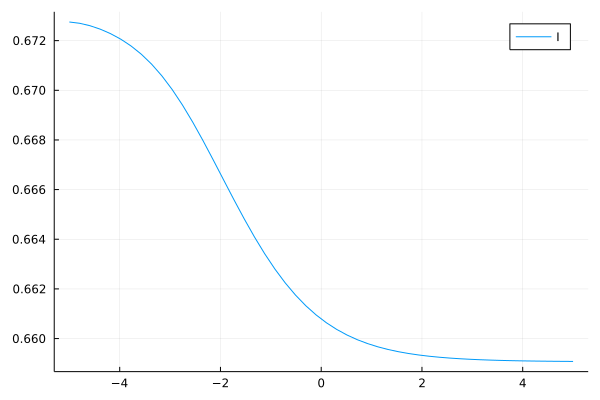

In [4]:
function ratio(x, brn, ϵ)
    y = brn + ϵ * sin(2 * pi * x)
    return y
end
prob = probgeneration!(ratio, γ, initS, initI, dx)
brn = 3.0
ϵ = 2.0
p = [1.0, 1.0, brn, ϵ]

@time episize!(prob, p, n);
Ilim = Dict("min" => -5.0, "max" => 5.0, "len" => 50)
vartype = "I"
@time epiresultI = episingle!(prob, vartype, Ilim, p, n);
plotdI(Ilim, epiresultI, vartype)

## Important Notes

###  dS, dI, $\tau$ are expotential scale

### $\epsilon$ and $brn$ (reproduction numbers) are linear, true value

### Five kind of free parameters: $dS, dI, \tau = dI/dS, brn, \epsilon$

# Validation of Theorem 1.4

In [6]:
Ilim = Dict("min" => 2.0, "max" => 500.0, "len" => 100)
vartype = "R"
@time epiresultI = episingle!(prob, vartype, Ilim, p, n);

  0.089989 seconds (58.87 k allocations: 10.611 MiB, 73.29% compilation time)


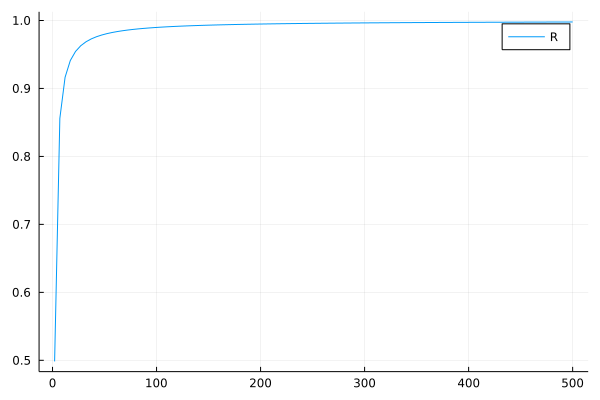

In [7]:
plotdI(Ilim, epiresultI, vartype)

# Level set of dI and $\epsilon$

In [29]:
Ilim = Dict("min" => 0.0, "max" => 3.0, "len" => 20)
Slim = Dict("min" => -5.0, "max" => 5.0, "len" => 20)
leveltype = "IE"
@time epiresultSI = levelset(prob,leveltype,Slim, Ilim, p, n);

  0.275506 seconds (389.51 k allocations: 51.018 MiB, 68.80% compilation time)


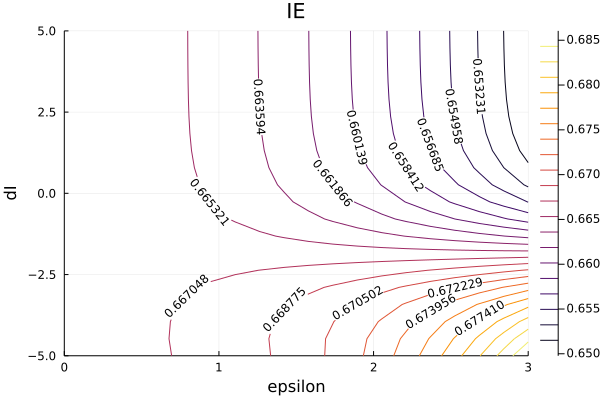

In [19]:
nlevels = 20
plotSI(Slim, Ilim, epiresultSI, leveltype, nlevels);
xlabel!("epsilon")
ylabel!("dI")

  0.051518 seconds (35.11 k allocations: 9.083 MiB, 14.56% compilation time)


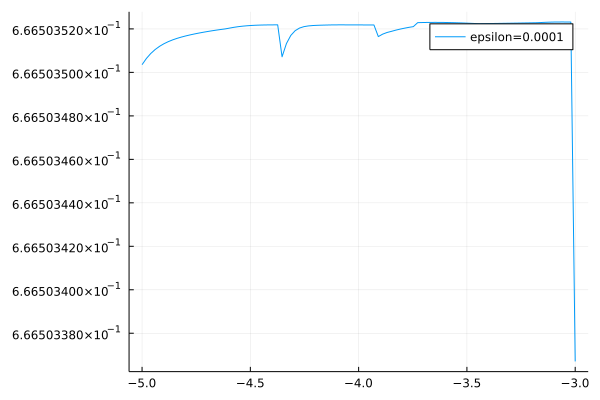

In [12]:
Ilim = Dict("min" => -5.0, "max" => -3.0, "len" => 100)
vartype = "I"
ϵ = 0.0001
p = [1.0, 1.0, brn, ϵ]
@time epiresultI = episingle!(prob, vartype, Ilim, p, n);
N_range = range(Ilim["min"], Ilim["max"], length=Ilim["len"])
figure = plot(N_range, epiresultI, label="epsilon=$ϵ")

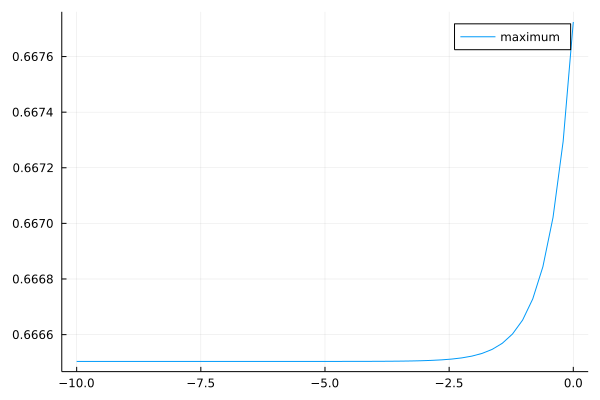

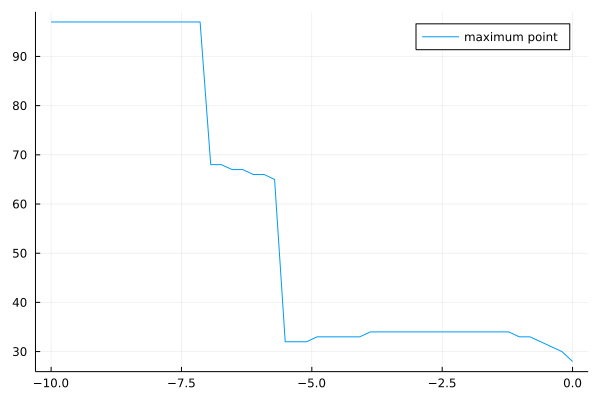

In [9]:


Ilim = Dict("min" => -5.0, "max" => -3.0, "len" => 100)
ϵ = 2.0
p = [1.0, 1.0, brn, ϵ]

Elim = Dict("min" => -10.0, "max" => 0.0, "len" => 50)
Epsilon_range = range(Elim["min"], Elim["max"], length=Elim["len"])
maxvalue, maxvalueindex = findmaximum!(Ilim, Elim)
display(plot(Epsilon_range,maxvalue,label ="maximum"))
display(plot(Epsilon_range, maxvalueindex, label="maximum point"))

In [13]:
Ilim = Dict("min" => -5.0, "max" => -3.0, "len" => 100)
ϵ = 2.0
p = [1.0, 1.0, brn, ϵ]

Elim = Dict("min" => -5.0, "max" => 1.0, "len" => 50)
Epsilon_range = range(Elim["min"], Elim["max"], length=Elim["len"])
maxvalue, maxvalueindex = findmaximum!(Ilim, Elim)
display(plot(Epsilon_range,maxvalue,label ="maximum"))
display(plot(Epsilon_range, maxvalueindex, label="maximum point"))

: 

: 

# Level Set of $(dI,\tau)$

  0.463255 seconds (494.72 k allocations: 73.595 MiB, 59.14% compilation time)


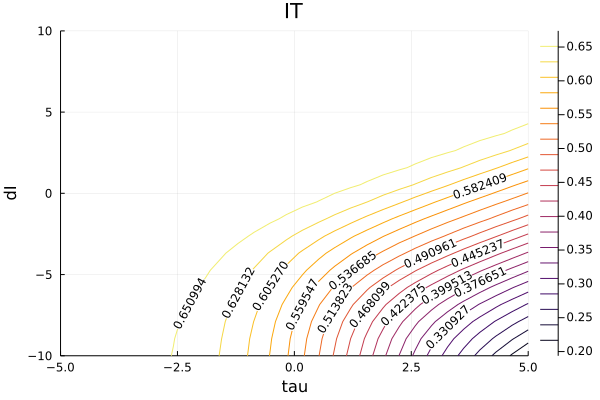

In [8]:
p = [0.5, 0.05, brn, ϵ]
Ilim = Dict("min" => -5.0, "max" => 5.0, "len" => 30)
Slim = Dict("min" => -10.0, "max" => 10.0, "len" => 20)
leveltype = "IT"
@time epiresultSI = levelset(prob, leveltype, Slim, Ilim, p, n);
nlevels = 20
plotSI(Slim, Ilim, epiresultSI, leveltype, nlevels);
xlabel!("tau")
ylabel!("dI")

# Vlidation of Theorem 1.2

- If either $H^{-}\ne\emptyset$  or $H^{-}=\emptyset$ and $\int_{\Omega}\frac{\mathfrak{R}}{\mathfrak{R}-1}=\infty$, then $\int_{\Omega}I(\cdot,d_S,d_I)\to 0$ as $d_S\to 0^+$.
- If $H^{-}=\emptyset$ and $\int_{\Omega}\frac{\mathfrak{R}}{\mathfrak{R}-1}<\infty$, then $\int_{\Omega}I(\cdot,d_S,d_I)\to \frac{N|\Omega|}{\int_{\Omega}\frac{\mathfrak{R}}{\mathfrak{R}-1}}$ as $d_S\to 0^+$. 

Epidemic size as a function of $\epsilon$

Here, $$\beta(x)= 3.0+  \epsilon \sin(2  \pi  x)$$

In [ ]:
p = [exp(-15), 0.05, brn, ϵ]
Ilim = Dict("min" => -5.0, "max" => 5.0, "len" => 100)
vartype = "tS"
@time epiresultI = episingle!(prob, vartype, Ilim, p, n)

The mapping $(0,\infty)\ni d_{S}\mapsto \frac{d_I}{d_S}\int_{\Omega}I(\cdot,d_S,d_I)$ is strictly decreasing

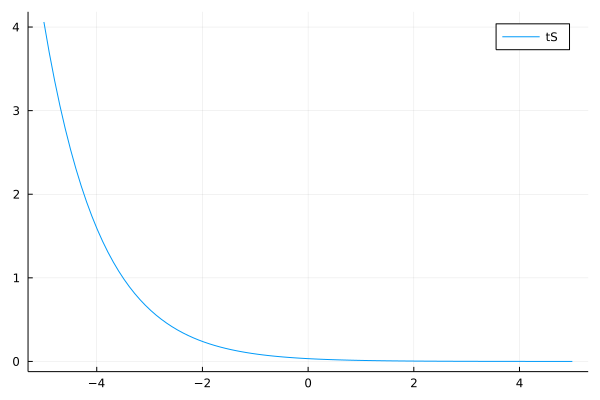

In [21]:
plotdI(Ilim, epiresultI, vartype)

In [16]:
Ilim = Dict("min" => 0.0, "max" => 3.0, "len" => 20)
Slim = Dict("min" => -5.0, "max" => 5.0, "len" => 20)
leveltype = "SI"
@time epiresultSI = levelset(prob,leveltype,Slim, Ilim, p, n);

  0.207347 seconds (161.79 k allocations: 39.588 MiB)


0.0%┣                                               ┫ 0/20 [00:00<00:-1, -0s/it]
0.0%┣                                               ┫ 0/20 [00:00<00:-1, -0s/it]
5.0%┣██▏                                        ┫ 1/20 [00:00<Inf:Inf, InfGs/it]
0.0%┣                                               ┫ 0/20 [00:00<00:-1, -0s/it]
0.0%┣                                               ┫ 0/20 [00:00<00:-1, -0s/it]
0.0%┣                                               ┫ 0/20 [00:00<00:-1, -0s/it]
0.0%┣                                               ┫ 0/20 [00:00<00:-1, -0s/it]
45.0%┣████████████████████▊                         ┫ 9/20 [00:00<00:00, 72it/s]
75.0%┣█████████████████████████████████▊           ┫ 15/20 [00:00<00:00, 81it/s]


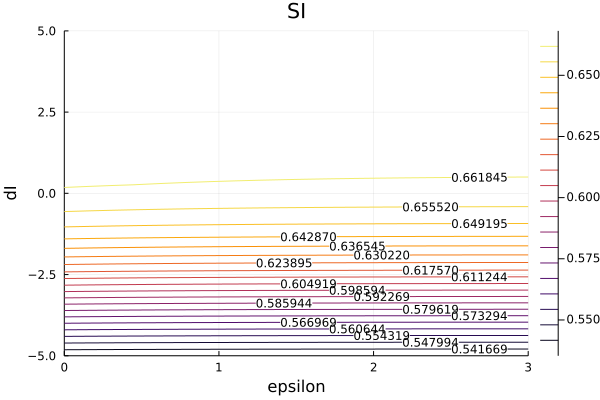

In [17]:
nlevels = 20
plotSI(Slim, Ilim, epiresultSI, leveltype, nlevels);
xlabel!("epsilon")
ylabel!("dI")

### level set of $\frac{d_I}{d_S}\int_{\Omega}I(\cdot,d_S,d_I)$ on (dS,dI)

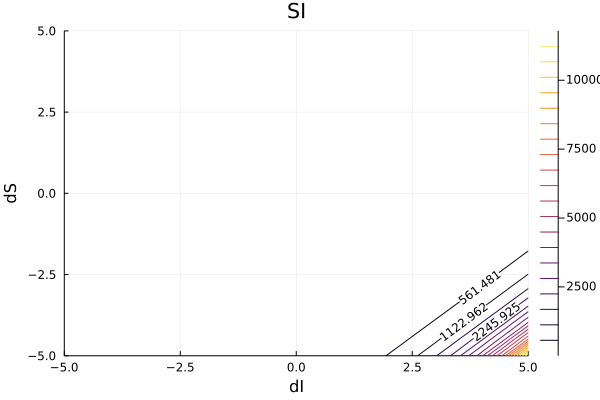

In [36]:
nlevels = 20
plotSI(Slim, Ilim, epiresultSI, leveltype, nlevels);
xlabel!("dI")
ylabel!("dS")

In [ ]:
p = [exp(-15), 0.05, brn, ϵ]
Ilim = Dict("min" => -3.0, "max" => 3.0, "len" => 100)
vartype = "E"
@time epiresultI = episingle!(prob, vartype, Ilim, p, n)


Parameter values: A1: -11.999963291721539; A2: 6.411891286969424e11; A3: 1.7130215650208743e22


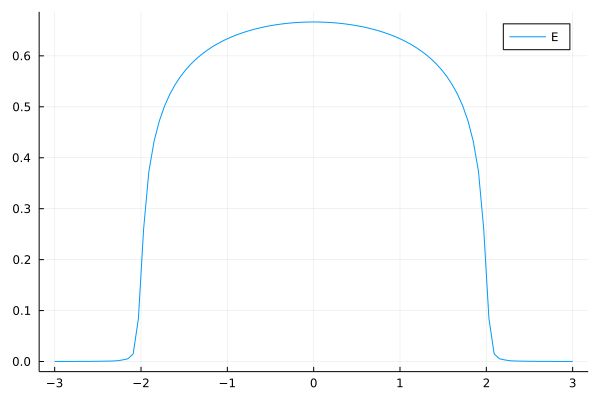

In [39]:
τ = p[2] / p[1];
A1_value = A1(τ,brn)
A2_value = A2(τ,brn)
A3_value = A3(τ,brn)
println("Parameter values: A1: $A1_value; A2: $A2_value; A3: $A3_value")
plotdI(Ilim, epiresultI, vartype)

In [40]:
p = [exp(-10), 1.0, brn, ϵ]
Ilim = Dict("min" => 0.0, "max" => 15.0, "len" => 100)
vartype = "S"
@time epiresultI = episingle!(prob, vartype, Ilim, p, n);


  0.089556 seconds (45.27 k allocations: 10.567 MiB)


0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
1.0%┣▍                                         ┫ 1/100 [00:00<Inf:Inf, InfGs/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]


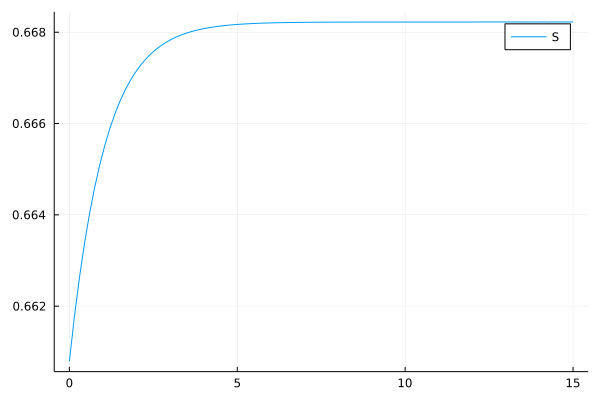

In [41]:
plotdI(Ilim, epiresultI, vartype)

In [45]:
p = [exp(-10), 1.0, brn, ϵ]
Ilim = Dict("min" => 0.0, "max" => 15.0, "len" => 100)
vartype = "I"
@time epiresultI = episingle!(prob, vartype, Ilim, p, n);


  0.052999 seconds (48.41 k allocations: 11.045 MiB)


0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
1.0%┣▍                                         ┫ 1/100 [00:00<Inf:Inf, InfGs/it]
100.0%┣████████████████████████████████████████┫ 100/100 [00:00<00:00, 1.1kit/s]


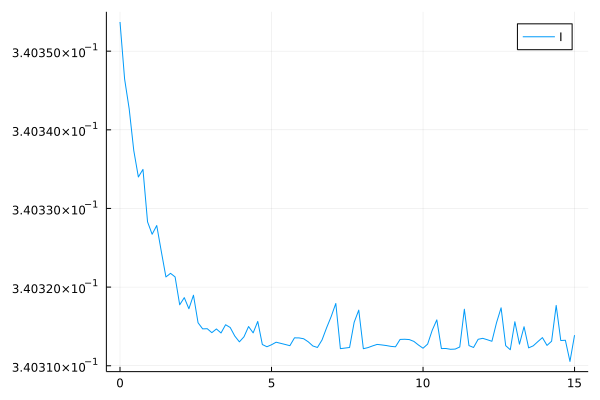

In [46]:
plotdI(Ilim, epiresultI, vartype)

# Validation of Theorem 1.3(i,ii)

Episize as a function of $\epsilon $


- If  $\tilde{A}_1\le 0$, then there is $0<\varepsilon_*<\frac{1}{\|h\|_{\infty}}$, depending on $h,d_I,c$ and $\frac{d_I}{d_S}$, such that 

$$
\int_{\Omega}I(\cdot,d_S,d_I,c,\varepsilon)<\int_{\Omega}I(\cdot,d_S,d_I,c,0)  \quad \text{for} \quad 0< |\varepsilon|<\varepsilon_*.
$$

- If $d_I\lambda_1\tilde{A}_1>\tilde{A}_2$,  
then  there is $0<\varepsilon_*<\frac{1}{\|h\|_{\infty}}$, depending on $h,d_I,c$ and $\frac{d_I}{d_S}$, such that 
$$
\int_{\Omega}I(\cdot,d_S,d_I,c,\varepsilon)>\int_{\Omega}I(\cdot,d_S,d_I,c,0)  \quad \text{for}\quad \ 0<|\varepsilon|<\varepsilon_*.
$$

### Theorem1.3(i)

Set $A1 = 0$ for example;



In [ ]:
p = [0.1, 0.05, brn, ϵ]
Ilim = Dict("min" => -3.0, "max" => 3.0, "len" => 100)
vartype = "E"
@time epiresultI = episingle!(prob, vartype, Ilim, p, n)


Parameter values: A1: 0.0; A2: 10.0; A3: 6.0


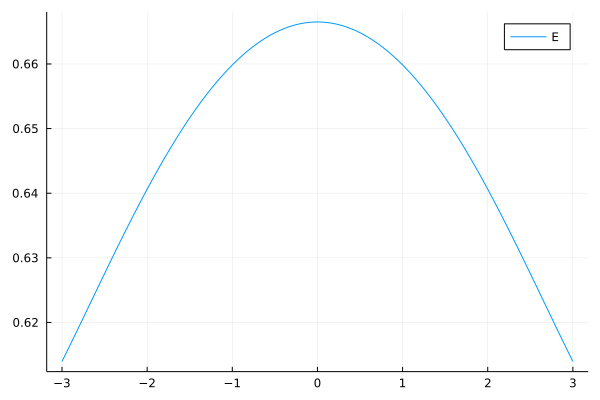

In [48]:
τ = p[2] / p[1];
A1_value = A1(τ,brn)
A2_value = A2(τ,brn)
A3_value = A3(τ,brn)
println("Parameter values: A1: $A1_value; A2: $A2_value; A3: $A3_value")
plotdI(Ilim, epiresultI, vartype)

In [ ]:
p = [0.01, 0.05, brn, ϵ]
Ilim = Dict("min" => -3.0, "max" => 3.0, "len" => 100)
vartype = "E"
@time epiresultI = episingle!(prob, vartype, Ilim, p, n)


Parameter values: A1: -10.8; A2: 622.0; A3: 18150.0


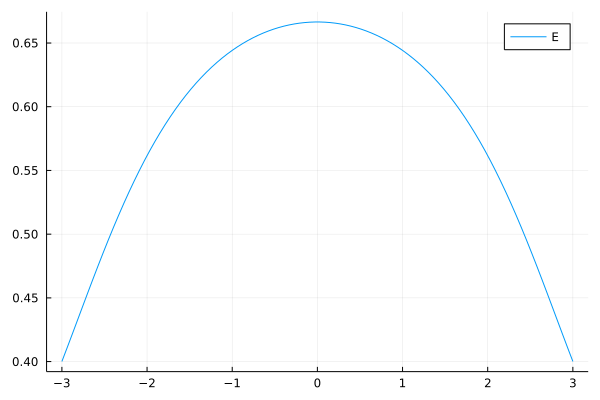

In [37]:
τ = p[2] / p[1];
A1_value = A1(τ,brn)
A2_value = A2(τ,brn)
A3_value = A3(τ,brn)
println("Parameter values: A1: $A1_value; A2: $A2_value; A3: $A3_value")
plotdI(Ilim, epiresultI, vartype)

In [ ]:
p = [10, 0.05, brn, ϵ]
Ilim = Dict("min" => -3.0, "max" => 3.0, "len" => 100)
vartype = "E"
@time epiresultI = episingle!(prob, vartype, Ilim, p, n)


### Theorem1.3(ii)

Set $A1$ large enough;

Parameter values: A1: 1187.9999999999998; A2: 2.0206; A3: 0.00015301500000000002


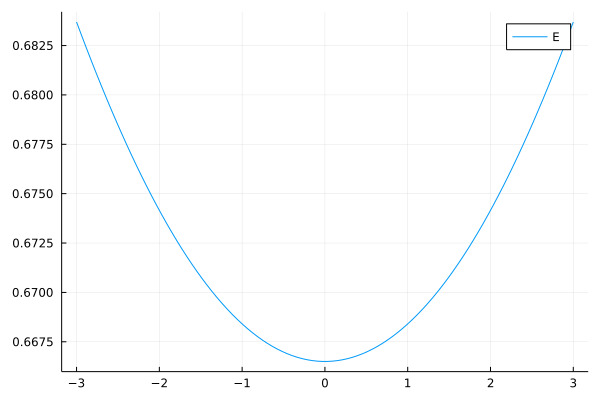

In [35]:
τ = p[2] / p[1];
A1_value = A1(τ,brn)
A2_value = A2(τ,brn)
A3_value = A3(τ,brn)
println("Parameter values: A1: $A1_value; A2: $A2_value; A3: $A3_value")
plotdI(Ilim, epiresultI, vartype)

### Moderate value


In [ ]:
p = [0.5, 0.05, brn, ϵ]
Ilim = Dict("min" => -3.0, "max" => 3.0, "len" => 100)
vartype = "E"
@time epiresultI = episingle!(prob, vartype, Ilim, p, n)


Parameter values: A1: 48.00000000000001; A2: 2.64; A3: 0.08640000000000002


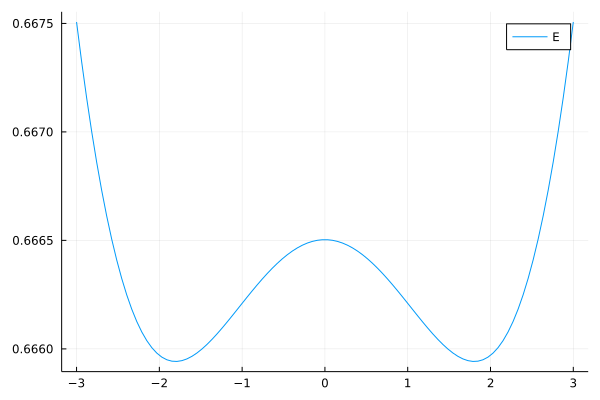

In [44]:
τ = p[2] / p[1];
A1_value = A1(τ,brn)
A2_value = A2(τ,brn)
A3_value = A3(τ,brn)
println("Parameter values: A1: $A1_value; A2: $A2_value; A3: $A3_value")
plotdI(Ilim, epiresultI, vartype)

# Episize as a decreasing function of $\tau$

In [ ]:
p = [0.01, 0.05, brn, ϵ]
Ilim = Dict("min" => -3.0, "max" => 3.0, "len" => 100)
vartype = "T"
@time epiresultI = episingle!(prob, vartype, Ilim, p, n)


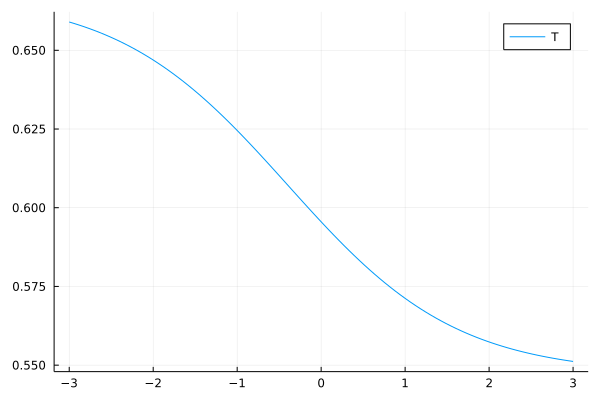

In [7]:
plotdI(Ilim, epiresultI, vartype)

# Level Set of dS, dI

In [50]:
Ilim = Dict("min" => -10.0, "max" => 10.0, "len" => 50)
Slim = Dict("min" => -10.0, "max" => 10.0, "len" => 50)
leveltype = "SI"
@time epiresultSI = levelset(prob,leveltype,Slim, Ilim, p, n);

0.0%┣                                               ┫ 0/50 [00:00<00:-3, -0s/it]
0.0%┣                                               ┫ 0/50 [00:00<00:-3, -0s/it]
0.0%┣                                               ┫ 0/50 [00:00<00:-3, -0s/it]
2.0%┣▉                                          ┫ 1/50 [00:00<Inf:Inf, InfGs/it]
0.0%┣                                               ┫ 0/50 [00:00<00:-3, -0s/it]
0.0%┣                                               ┫ 0/50 [00:00<00:-3, -0s/it]
0.0%┣                                               ┫ 0/50 [00:00<00:-3, -0s/it]
10.0%┣████▋                                         ┫ 5/50 [00:00<00:02, 29it/s]
22.0%┣██████████                                   ┫ 11/50 [00:00<00:01, 46it/s]
30.0%┣█████████████▌                               ┫ 15/50 [00:00<00:01, 52it/s]
38.0%┣█████████████████                            ┫ 19/50 [00:00<00:01, 53it/s]
48.0%┣█████████████████████▋                       ┫ 24/50 [00:00<00:00, 57it/s]
56.0%┣██████████████████████

  0.744327 seconds (1.07 M allocations: 256.488 MiB)


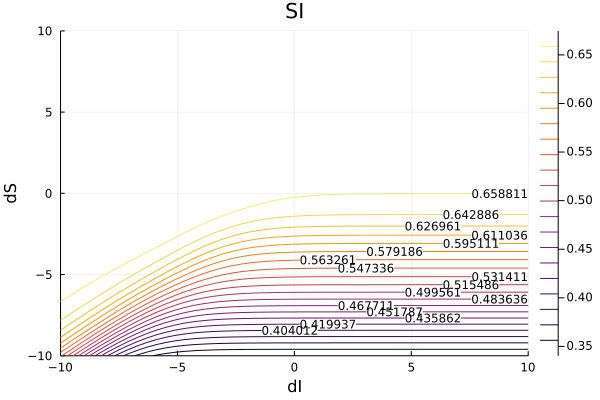

In [51]:
nlevels = 20
Ilim = Dict("min" => -10.0, "max" => 10.0, "len" => 50)
Slim = Dict("min" => -10.0, "max" => 10.0, "len" => 50)
plotSI(Slim, Ilim, epiresultSI, leveltype, nlevels);
xlabel!("dI")
ylabel!("dS")

In [53]:
p = [exp(-10), 0.05, brn, ϵ]
Ilim = Dict("min" => -10.0, "max" => 10.0, "len" => 100)
vartype = "I"
@time epiresultI = episingle!(prob, vartype, Ilim, p, n);

  0.051903 seconds (46.05 k allocations: 10.683 MiB)


0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
1.0%┣▍                                         ┫ 1/100 [00:00<Inf:Inf, InfGs/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]


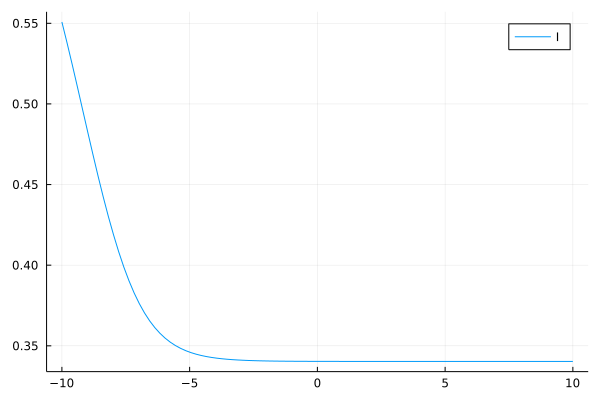

In [54]:
plotdI(Ilim, epiresultI, vartype)

# Level Set of $dS$, $\tau$

In [ ]:
p = [0.5, 0.05, brn, ϵ]
Ilim = Dict("min" => -5.0, "max" => 5.0, "len" => 30)
Slim = Dict("min" => -10.0, "max" => 10.0, "len" => 20)
leveltype = "ST"
@time epiresultSI = levelset(prob, leveltype, Slim, Ilim, p, n);

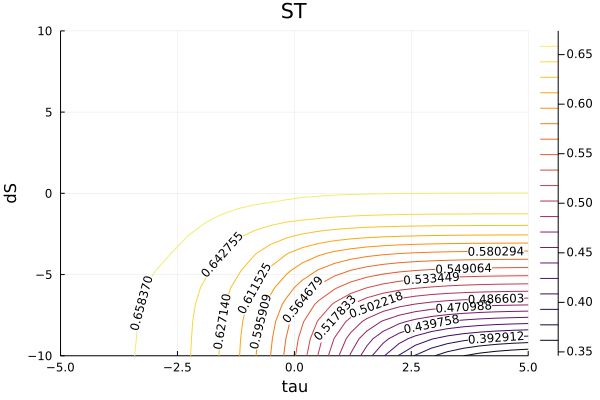

In [25]:
nlevels = 20
plotSI(Slim, Ilim, epiresultSI,leveltype, nlevels);
xlabel!("tau")
ylabel!("dS")

# Level Set of $\tau$ (or $-A1$), $\epsilon$

In [26]:
p = [0.5, 0.05, brn, ϵ]
Ilim = Dict("min" => -2.0, "max" => 2.0, "len" => 20)
Slim = Dict("min" => -5.0, "max" => 2.0, "len" => 20)
leveltype = "TE"
@time epiresultSI = levelset(prob,leveltype,Slim, Ilim, p, n);

  0.123065 seconds (145.45 k allocations: 37.171 MiB)


0.0%┣                                               ┫ 0/20 [00:00<00:-1, -0s/it]
0.0%┣                                               ┫ 0/20 [00:00<00:-1, -0s/it]
0.0%┣                                               ┫ 0/20 [00:00<00:-1, -0s/it]
0.0%┣                                               ┫ 0/20 [00:00<00:-1, -0s/it]
5.0%┣██▏                                        ┫ 1/20 [00:00<Inf:Inf, InfGs/it]
0.0%┣                                               ┫ 0/20 [00:00<00:-1, -0s/it]
0.0%┣                                               ┫ 0/20 [00:00<00:-1, -0s/it]
80.0%┣███████████████████████████████████▏        ┫ 16/20 [00:00<00:00, 129it/s]


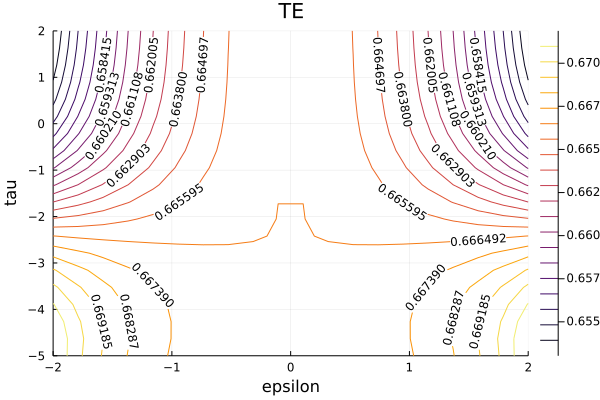

In [27]:
nlevels = 20
plotSI(Slim, Ilim, epiresultSI,leveltype, nlevels);
xlabel!("epsilon")
ylabel!("tau")

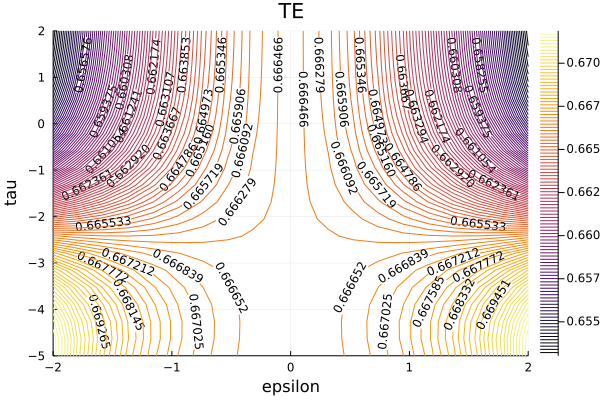

In [28]:
nlevels = 100
plotSI(Slim, Ilim, epiresultSI,leveltype, nlevels);
xlabel!("epsilon")
ylabel!("tau")

# Level Set of $dS$, $\epsilon$

In [ ]:
p = [0.5, 0.05, brn, ϵ]
Ilim = Dict("min" => -3.0, "max" => 3.0, "len" => 20)
Slim = Dict("min" => -10.0, "max" => 2.0, "len" => 20)
leveltype = "SE"
@time epiresultSI = levelset(prob,leveltype,Slim, Ilim, p, n);

### Theorem 1.2 (i,ii)

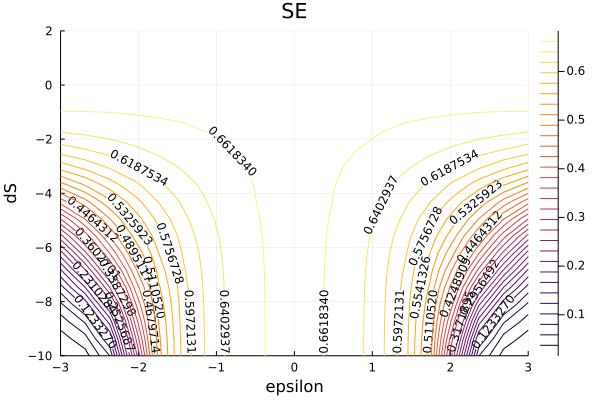

In [30]:
nlevels = 30
plotSI(Slim, Ilim, epiresultSI,leveltype, nlevels);
xlabel!("epsilon")
ylabel!("dS")

# More $\gamma(x)$ and level set of $(dS,dI)$


  6.295603 seconds (11.97 M allocations: 713.395 MiB, 3.80% gc time, 99.98% compilation time)
  3.140331 seconds (5.76 M allocations: 540.622 MiB, 2.25% gc time, 77.37% compilation time)


┌ Warning: : no method matching get_unit for arguments (Pair{Num, Float64},).
└ @ ModelingToolkit F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\ModelingToolkit\iHLWM\src\systems\validation.jl:144
┌ Warning: : no method matching get_unit for arguments (Pair{Num, Float64},).
└ @ ModelingToolkit F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\ModelingToolkit\iHLWM\src\systems\validation.jl:144
┌ Warning: : no method matching get_unit for arguments (Pair{Num, Float64},).
└ @ ModelingToolkit F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\ModelingToolkit\iHLWM\src\systems\validation.jl:144
┌ Warning: : no method matching get_unit for arguments (Pair{Num, Float64},).
└ @ ModelingToolkit F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\ModelingToolkit\iHLWM\src\systems\validation.jl:144
0.0%┣                                               ┫ 0/50 [00:00<00:-3, -0s/it]
0.0%┣                                               ┫ 0/50 [00:00<00:-3, -0s/it]
2.0%┣▉                                        

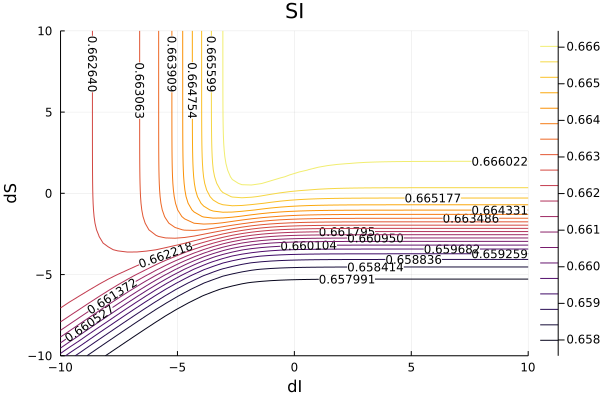

In [5]:
function ratio(x, brn, ϵ)
    y = brn + ϵ * (exp(x)-x+1.5-exp(1.0))
    return y
end
prob = probgeneration!(ratio, γ, initS, initI, dx)
brn = 3.0
ϵ = 2.0
p = [1.0, 1.0, brn, ϵ]

@time episize!(prob, p, n)

Ilim = Dict("min" => -10.0, "max" => 10.0, "len" => 50)
Slim = Dict("min" => -10.0, "max" => 10.0, "len" => 50)
leveltype = "SI"
@time epiresultSI = levelset(prob, leveltype, Slim, Ilim, p, n);

nlevels = 20
Ilim = Dict("min" => -10.0, "max" => 10.0, "len" => 50)
Slim = Dict("min" => -10.0, "max" => 10.0, "len" => 50)
plotSI(Slim, Ilim, epiresultSI, leveltype, nlevels);
xlabel!("dI")
ylabel!("dS")

In [6]:
p = [0.1, 1.0, brn, ϵ]
Ilim = Dict("min" => -10.0, "max" => 10.0, "len" => 100)
vartype = "I"
@time epiresultI = episingle!(prob, vartype, Ilim, p, n);
plotdI(Ilim, epiresultI, vartype)

  0.375329 seconds (300.40 k allocations: 23.766 MiB, 77.80% compilation time)


0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
1.0%┣▍                                         ┫ 1/100 [00:00<Inf:Inf, InfGs/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]


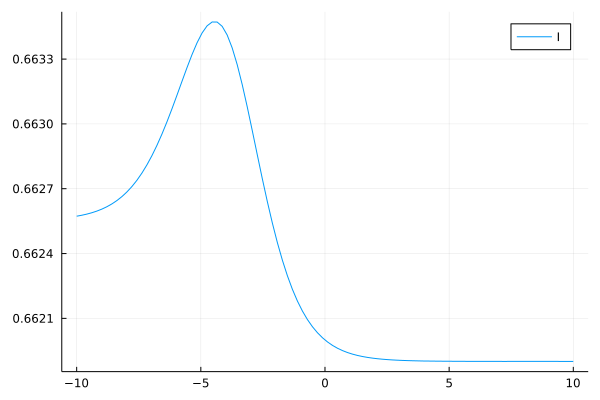

In [7]:
plotdI(Ilim, epiresultI, vartype)

  0.213475 seconds (205.32 k allocations: 59.267 MiB)


0.0%┣                                               ┫ 0/30 [00:00<00:-2, -0s/it]
0.0%┣                                               ┫ 0/30 [00:00<00:-2, -0s/it]
0.0%┣                                               ┫ 0/30 [00:00<00:-2, -0s/it]
0.0%┣                                               ┫ 0/30 [00:00<00:-2, -0s/it]
3.3%┣█▍                                         ┫ 1/30 [00:00<Inf:Inf, InfGs/it]
0.0%┣                                               ┫ 0/30 [00:00<00:-2, -0s/it]
0.0%┣                                               ┫ 0/30 [00:00<00:-2, -0s/it]
33.3%┣███████████████                              ┫ 10/30 [00:00<00:00, 81it/s]
73.3%┣████████████████████████████████▎           ┫ 22/30 [00:00<00:00, 118it/s]


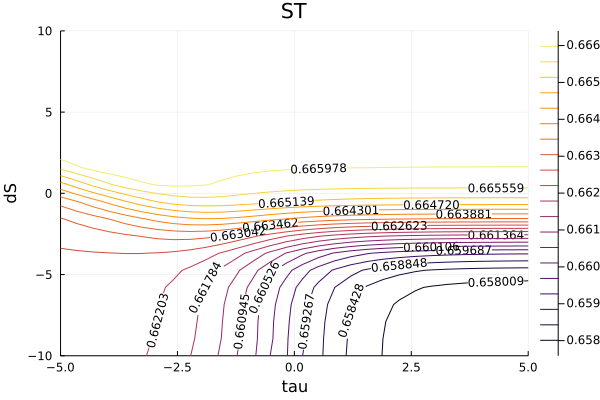

In [8]:
p = [0.5, 0.05, brn, ϵ]
Ilim = Dict("min" => -5.0, "max" => 5.0, "len" => 30)
Slim = Dict("min" => -10.0, "max" => 10.0, "len" => 20)
leveltype = "ST"
@time epiresultSI = levelset(prob, leveltype, Slim, Ilim, p, n);
nlevels = 20
plotSI(Slim, Ilim, epiresultSI, leveltype, nlevels);
xlabel!("tau")
ylabel!("dS")

  3.286699 seconds (3.32 M allocations: 970.797 MiB, 4.92% gc time)


0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
1.0%┣▍                                         ┫ 1/100 [00:00<Inf:Inf, InfGs/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
5.0%┣██▎                                           ┫ 5/100 [00:00<00:07, 14it/s]
11.0%┣████▉                                       ┫ 11/100 [00:00<00:04, 20it/s]
16.0%┣███████                                     ┫ 16/100 [00:01<00:03, 27it/s]
17.0%┣███████▌                                    ┫ 17/100 [00:01<00:04, 20it/s]
23.0%┣██████████▏                                 ┫ 23/100 [00:01<00:03, 23it/s]
27.0%┣███████████▉          

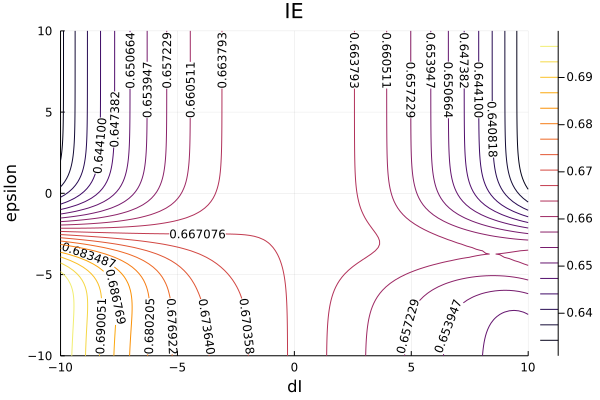

In [11]:
p = [0.5, 0.05, brn, ϵ]
Ilim = Dict("min" => -10.0, "max" => 10.0, "len" => 100)
Slim = Dict("min" => -10.0, "max" => 10.0, "len" => 100)
leveltype = "IE"
@time epiresultSI = levelset(prob, leveltype, Slim, Ilim, p, n);
nlevels = 20
plotSI(Slim, Ilim, epiresultSI, leveltype, nlevels);
xlabel!("dI")
ylabel!("epsilon")

  3.759175 seconds (3.49 M allocations: 1006.286 MiB, 5.09% gc time)


0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
1.0%┣▍                                         ┫ 1/100 [00:00<Inf:Inf, InfGs/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
4.0%┣█▉                                            ┫ 4/100 [00:00<00:08, 12it/s]
10.0%┣████▍                                       ┫ 10/100 [00:00<00:05, 19it/s]
13.0%┣█████▊                                      ┫ 13/100 [00:01<00:04, 23it/s]
16.0%┣███████                                     ┫ 16/100 [00:01<00:04, 23it/s]
18.0%┣████████                                    ┫ 18/100 [00:01<00:03, 24it/s]
21.0%┣█████████▎            

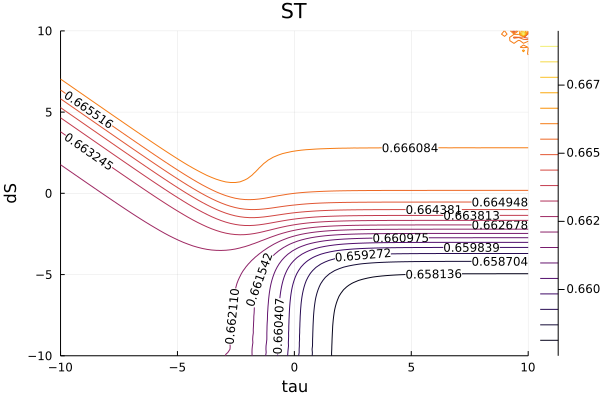

In [15]:
p = [0.5, 0.05, brn, ϵ]
Ilim = Dict("min" => -10.0, "max" => 10.0, "len" => 100)
Slim = Dict("min" => -10.0, "max" => 10.0, "len" => 100)
leveltype = "ST"
@time epiresultSI = levelset(prob, leveltype, Slim, Ilim, p, n);
nlevels = 20
plotSI(Slim, Ilim, epiresultSI, leveltype, nlevels);
xlabel!("tau")
ylabel!("dS")

  0.561172 seconds (860.68 k allocations: 57.435 MiB, 96.71% compilation time)


0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
1.0%┣▍                                         ┫ 1/100 [00:00<Inf:Inf, InfGs/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
4.0%┣█▉                                            ┫ 4/100 [00:00<00:04, 25it/s]
20.0%┣████████▋                                  ┫ 20/100 [00:00<00:01, 105it/s]
40.0%┣█████████████████▏                         ┫ 40/100 [00:00<00:00, 168it/s]
67.0%┣████████████████████████████▉              ┫ 67/100 [00:00<00:00, 214it/s]


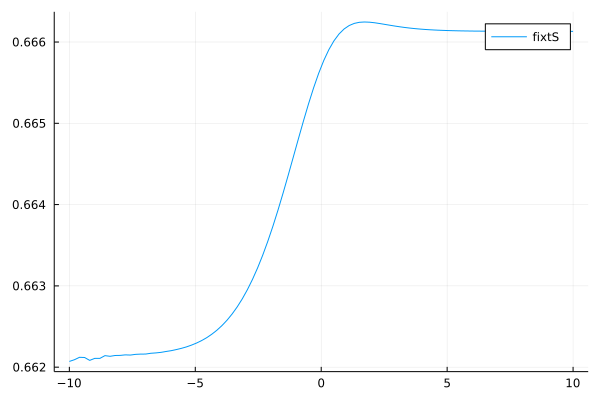

In [21]:
p = [0.1, 1.0, brn, ϵ]
Ilim = Dict("min" => -10.0, "max" => 10.0, "len" => 100)
vartype = "fixtS"
@time epiresultI = episingle!(prob, vartype, Ilim, p, n);
plotdI(Ilim, epiresultI, vartype)